In [ ]:
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('PDC_Project.csv')
df.head()

,Unnamed: 0,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,0,0,82,2000,1,0,1254.0,2000.0
1,1,0,82,2000,1,46,2.0,1.0
2,2,0,82,2000,1,59,102.0,321.0
3,3,0,82,2000,4,3,176.0,641.0
4,4,0,82,2000,4,12,720.0,165.0


In [ ]:
y = df["Production"].values
y

array([2.00e+03, 1.00e+00, 3.21e+02, ..., 3.09e+02, 1.94e+02, 1.70e+01])

In [ ]:
x = df.drop(["Unnamed: 0", "State_Name", "District_Name", "Crop_Year", "Season"], axis = 1)
x = x.values
x

array([[0.000e+00, 1.254e+03, 2.000e+03],
       [4.600e+01, 2.000e+00, 1.000e+00],
       [5.900e+01, 1.020e+02, 3.210e+02],
       ...,
       [7.400e+01, 1.778e+03, 3.090e+02],
       [2.400e+01, 2.160e+02, 1.940e+02],
       [2.800e+01, 5.100e+01, 1.700e+01]])

In [ ]:
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)

In [ ]:
x_train_standardized = (x_train - x_train .mean()) / x_train.std()
x_test_standardized  = (x_test - x_train.mean()) /  x_train.std()

## Serial Code

In [ ]:
import time
from numba import config, njit, set_num_threads, prange

def error_function(y_actual,y_predicted):
    error = 0
    for i in range(0,len(y_actual)):
        error =  error + pow((y_actual[i] - y_predicted[i]),2)
        return error/(2*len(y_actual))

def y_predicted(w,x):
    y_pred = np.zeros(len(x))
    for i in range(0,len(x)):
        for j in range(0,len(w)):
            y_pred[i] = y_pred[i]+(w[j]*x[i][j] + w[-1])
    return y_pred

def gradient_descent(y_actual,y_pred,x):
    grad = np.zeros(x.shape[1])
    for i in range(x.shape[1]):
        for j in range(0,len(y_actual)):
            grad[i] = - (y_actual[j] - y_pred[j])*x[j][i] + grad[i]
    return grad/len(y_actual)

def weights(x_train,y_train,num_iterations,learning_rate):
    no_of_rows = x_train.shape[0]
    no_of_columns = x_train.shape[1]
    new_x_train = np.ones((no_of_rows,no_of_columns+1))
    new_x_train[:,0:no_of_columns] = x_train
    w = np.zeros(no_of_columns)
    w =np.append(w,1)
    for i in range(0,num_iterations):
        y_pred = y_predicted(w,new_x_train)
        error = error_function(y_train,y_pred)
        #print("mean square error: ",error,"after",i,"th iteration")
        MSE_points.append(error)
        grad = gradient_descent(y_train,y_pred,new_x_train)
        w = w - learning_rate*grad
        learning_rate = learning_rate/1.05                               
    return w

def regression_test(x_test,w):
    row = x_test.shape[0]
    column = x_test.shape[1]
    new_x_test = np.ones((row,column+1))
    new_x_test[:,0:column] = x_test
    y_pred = y_predicted(w,new_x_test)
    return(y_pred)

In [ ]:
start = time.time()
MSE_points = []
num_iterations = 300
learning_rate = 0.1
w = weights(x_train_standardized,y_train,num_iterations,learning_rate)
Y_pred = regression_test(x_test_standardized,w)
error_function(y_test,Y_pred)
end = time.time()
print("Time taken = ",(end-start), "seconds")

Time taken =  110.83039665222168 seconds


In [ ]:
pred_df = pd.DataFrame({'Actual Value' : y_test, 'Predicted Values' : Y_pred,})
pred_df.head(10)

,Actual Value,Predicted Values
0,1762.0,2624.420511
1,22884.0,23724.120205
2,62.0,926.209663
3,3711.0,4571.259564
4,141.0,1005.127183
5,61.0,925.215671
6,2048.0,2910.089373
7,108.0,972.162142
8,250.0,1114.014886
9,14.0,878.262165


## Parallel Code

In [ ]:
import time
from numba import config, njit, set_num_threads, prange, int32
config.THREADING_LAYER = 'omp'


def error_function(y_actual,y_predicted):
    error = 0
    for i in range(0,len(y_actual)):
        error =  error + pow((y_actual[i] - y_predicted[i]),2)
        return error/(2*len(y_actual))

@njit(parallel=True)
def y_predicted(w,x):
    y_pred = np.zeros(len(x))
    for i in range(0,len(x)):
        for j in range(0,len(w)):
            y_pred[i] = y_pred[i]+(w[j]*x[i][j] + w[-1])
    return y_pred

def gradient_descent(y_actual,y_pred,x):
    grad = np.zeros(x.shape[1])
    for i in range(x.shape[1]):
        for j in range(0,len(y_actual)):
            grad[i] = - (y_actual[j] - y_pred[j])*x[j][i] + grad[i]
    return grad/len(y_actual)

def weights(x_train,y_train,num_iterations,learning_rate):
    no_of_rows = x_train.shape[0]
    no_of_columns = x_train.shape[1]
    new_x_train = np.ones((no_of_rows,no_of_columns+1))
    new_x_train[:,0:no_of_columns] = x_train
    w = np.zeros(no_of_columns)
    w =np.append(w,1)
    for i in range(0,num_iterations):
        y_pred = y_predicted(w,new_x_train)
        error = error_function(y_train,y_pred)
        #print("mean square error: ",error,"after",i,"th iteration")
        MSE_points.append(error)
        grad = gradient_descent(y_train,y_pred,new_x_train)
        w = w - learning_rate*grad
        learning_rate = learning_rate/1.05                                
    return w

def regression_test(x_test,w):
    row = x_test.shape[0]
    column = x_test.shape[1]
    new_x_test = np.ones((row,column+1))
    new_x_test[:,0:column] = x_test
    y_pred = y_predicted(w,new_x_test)
    return(y_pred)

In [ ]:
Time = []
for i in [2, 4, 8, 16, 32, 64, 128]:
    config.NUMBA_NUM_THREADS = i
    start = time.time()
    MSE_points = []
    num_iterations = 300
    learning_rate = 0.1
    w = weights(x_train_standardized,y_train,num_iterations,learning_rate)
    Y_pred = regression_test(x_test_standardized,w)
    error_function(y_test,Y_pred)
    end = time.time()
    Time.append((end-start))
    print("For " + str(i)  + " threads, " + "Time taken = ",(end-start), "seconds")

For 2 threads, Time taken =  56.57306146621704 seconds
For 4 threads, Time taken =  55.48495316505432 seconds
For 8 threads, Time taken =  55.241859912872314 seconds
For 16 threads, Time taken =  55.46914529800415 seconds
For 32 threads, Time taken =  55.37310457229614 seconds
For 64 threads, Time taken =  55.77378273010254 seconds
For 128 threads, Time taken =  55.708341121673584 seconds


In [ ]:
Time.insert(0, 110.83039665222168)

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score

In [ ]:
pred_df = pd.DataFrame(
    {
        'Actual Value' : y_test, 
     'Predicted Values' : Y_pred,
    }
)
pred_df.head(10)

,Actual Value,Predicted Values
0,1762.0,2624.420511
1,22884.0,23724.120205
2,62.0,926.209663
3,3711.0,4571.259564
4,141.0,1005.127183
5,61.0,925.215671
6,2048.0,2910.089373
7,108.0,972.162142
8,250.0,1114.014886
9,14.0,878.262165


In [ ]:
 r2 = r2_score(y_test,Y_pred)
print("The R^2 value is: ",r2)

The R^2 value is:  0.9999988889179184


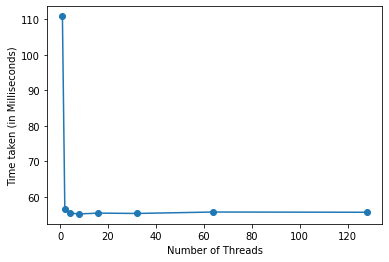

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
  
# define data values
x = np.array([1, 2, 4, 8, 16, 32, 64, 128])  
y = np.array(Time)
  
plt.plot(x, y, "-o")
plt.xlabel("Number of Threads")
plt.ylabel("Time taken (in Milliseconds)")
plt.show()